In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pyov2sgd as orff
import operalib as ovk
import numpy as np
import time
import ad
# from IPython import embed

In [6]:
np.random.seed(0)

n = 100000
d = 20
p = 4
X = np.random.rand(n, d)
Xtest = np.random.rand(n, d)

def phi(X):
    """Generate data according to Evgeniou, C. A. Micchelli, and M. Pontil.

    'Learning multiple tasks with kernel methods.' 2005.
    """
    return np.hstack((X[:, 0:1] ** 2,
                      X[:, 3:4] ** 2,
                      X[:, 0:1] * X[:, 1:2],
                      X[:, 2:3] * X[:, 4:5],
                      X[:, 1:2],
                      X[:, 3:4],
                      np.ones((n, 1))))

W = np.random.multivariate_normal(np.zeros(7), np.diag([0.5, 0.25, 0.1, 0.05, 0.15, 0.1, 0.15]), p)

y = np.dot(phi(X), W.T)
y += .1 * np.random.randn(y.shape[0], y.shape[1])

ytest = np.dot(phi(Xtest), W.T)
ytest += .1 * np.random.randn(ytest.shape[0], y.shape[1])

X = 2 * X - 1
Xtest = 2 * Xtest - 1

In [7]:
Dmax = 1000
Nmax = 2000
steps = 10

print('OVK N experiment')
isp = np.logspace(1, np.log10(n), steps).astype(np.int)
ovkt = np.zeros(isp.size)
ovke = np.zeros(isp.size)
for s, idx in enumerate(isp):
    if idx > Nmax:
        ovke[s:] = np.NaN
        ovkt[s:] = np.NaN
        break
    start = time.time()
    est = ovk.OVKRidge(gamma=.05, lbda=0.1, solver_params={'m': idx, 'pgtol':1e-10})
    est.fit(X[:idx, :], y[:idx, :])
    ovke[s] = est.score(Xtest, ytest)
    ovkt[s] = time.time() - start
    print(ovke[s], ovkt[s])

print('ORFF N experiment')
isp = np.logspace(1, np.log10(n), steps).astype(np.int)
rffe = np.zeros(isp.size)
rfft = np.zeros(isp.size)
for s, idx in enumerate(isp):
    start = time.time()
    est = ovk.ORFFRidge(D=Dmax, gamma=.05, lbda=0.1, solver_params={'m': Dmax, 'pgtol':1e-10})
    est.fit(X[:idx, :], y[:idx, :])
    rffe[s] = est.score(Xtest, ytest)
    rfft[s] = time.time() - start
    print(rffe[s], rfft[s])
    
print('OVK D experiment')
est = ovk.OVKRidge(gamma=.05, lbda=0.1, solver_params={'m': Nmax, 'pgtol':1e-10})
start = time.time()
est.fit(X[:Nmax, :], y[:Nmax, :])
ovkDe = est.score(Xtest, ytest)
ovkDt = time.time() - start
print(ovkDe, ovkDt)

print('ORFF D experiment')
isp = np.logspace(1, np.log10(Dmax), steps).astype(np.int)
rffDe = np.zeros(isp.size)
rffDt = np.zeros(isp.size)
for s, D in enumerate(isp):
    start = time.time()
    est = ovk.ORFFRidge(D=D, gamma=.05, lbda=0.1, solver_params={'m': D, 'pgtol':1e-10})
    est.fit(X[:Nmax, :], y[:Nmax, :])
    rffDe[s] = est.score(Xtest, ytest)
    rffDt[s] = time.time() - start
    print(rffDe[s], rffDt[s])

OVK N experiment
0.234615188248 0.300812005997
0.535098844881 0.481571912766
0.689516742631 1.15557408333
0.736019947824 3.42090797424
0.776870448528 13.3378410339
0.809582017975 77.7684431076
ORFF N experiment
0.236899674637 3.25367808342
0.527694412155 3.24317097664
0.67857710605 3.33247590065
0.724887464948 3.95000100136
0.764972994635 4.12881994247
0.80052722158 4.42109203339
0.819316882565 6.96377205849
0.828394395698 14.6614131927
0.833212992284 37.5540840626
0.83542827964 105.147078991
OVK D experiment
0.81402714 34.707985162734985
ORFF D experiment
-0.0368144784612 0.245158910751
0.227091452105 0.353313922882
0.515634909383 0.56730890274
0.61889119014 0.782570838928
0.709945680591 1.03770303726
0.762680167404 0.781269073486
0.770318057719 1.17836403847
0.786500961143 1.80804300308
0.796986700874 2.86650896072
0.804700804329 5.00238180161


In [ ]:
sns.set_style("whitegrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
s = -np.isnan(ovke).sum() - 1 if np.isnan(ovke).sum() > 0 else ovke.size - 1
ax1.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int), rffe, label='ORFF, D=' + str(Dmax), marker='s')
ax1.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int)[:s + 1], ovke[:s + 1], label='OVK', marker='v')
ax1.hlines(rffe.max(), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[-1], colors='b', linestyle='--')
ax1.hlines(np.nanmax(ovke), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[s], colors='g', linestyle='--')
ax1.set_xlabel('Data seen (N)')
ax1.set_ylabel('score (R2)')
ax1.legend(loc=4)

ax2.loglog(np.logspace(0, np.log10(n), steps).astype(np.int), rfft, label='ORFF, D=' + str(Dmax), marker='s')
ax2.loglog(np.logspace(0, np.log10(n), steps).astype(np.int)[:s + 1], ovkt[:s + 1], label='OVK', marker='v')
ax2.hlines(rfft.max(), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[-1], colors='b', linestyle='--')
ax2.hlines(np.nanmax(ovkt), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[s], colors='g', linestyle='--')
ax2.set_xlabel('Data seen (N)')
ax2.set_ylabel('time (s)')
ax2.legend(loc=4)

ax4.loglog(np.logspace(1, np.log10(Dmax), steps).astype(np.int), rffDt, label='ORFF', marker='s')
ax4.loglog(np.logspace(1, np.log10(Dmax), steps).astype(np.int), np.full(steps, ovkDt), label='OVK, N=' + str(Nmax), marker='v')
ax4.set_xlim(10, Dmax)
ax4.set_xlabel('Features (D)')
ax4.set_ylabel('time (s)')
ax4.legend(loc=4)

ax3.semilogx(np.logspace(1, np.log10(Dmax), steps).astype(np.int), rffDe, label='ORFF', marker='s')
ax3.semilogx(np.logspace(1, np.log10(Dmax), steps).astype(np.int), np.full(steps, ovkDe), label='OVK, N=' + str(Nmax), marker='v')
ax3.set_xlim(10, Dmax)
ax3.set_xlabel('Features (D)')
ax3.set_ylabel('score (R2)')
ax3.legend(loc=4)

plt.savefig("ORFFFvsOVK.pgf")
plt.show()

In [10]:
print('ORFF N experiment')
isp1 = np.logspace(1, np.log10(n), steps).astype(np.int)
isp2 = np.logspace(1, np.log10(Dmax), steps).astype(np.int)

rffe = np.zeros((isp1.size, isp2.size))
rfft = np.zeros((isp1.size, isp2.size))
for s1, idx in enumerate(isp1):
    for s2, D in enumerate(isp2):
        start = time.time()
        est = ovk.ORFFRidge(D=D, gamma=.05, lbda=0.1, solver_params={'m': Dmax, 'pgtol':1e-10})
        est.fit(X[:idx, :], y[:idx, :])
        rffe[s1, s2] = est.score(Xtest, ytest)
        rfft[s1, s2] = time.time() - start
        print(rffe[s1, s2], rfft[s1, s2])

ORFF N experiment
-0.917790658853 0.283803939819
-0.356146774527 0.331259965897
0.172413689557 0.461335897446
0.0736219324887 0.525009155273
0.163673313716 0.599048137665
0.266579420922 0.698402166367
0.169261658834 1.09928607941
0.215969102248 1.51482105255
0.214507792416 2.44471907616
0.236899674637 4.22577810287
-0.312648347909 0.295176029205
-0.409880494011 0.531150102615
0.290600952857 0.718662977219
0.352661943755 0.99985909462
0.412576339602 1.02828097343
0.545978638947 0.769212961197
0.459005261749 1.02333807945
0.504575061147 1.5333571434
0.51584049158 2.35116314888
0.527694412155 3.83248305321
-0.158247801586 0.295855998993
0.0358006383024 0.351642847061
0.321811279363 0.707407951355
0.440853003076 0.987231016159
0.527130871933 1.22736501694
0.647706364514 0.7262840271
0.636838712099 1.02663207054
0.655965947538 1.52430796623
0.680925244623 2.37596297264
0.67857710605 4.0233039856
-0.087920439663 0.332341909409
0.160369492595 0.701462984085
0.455195564609 0.839647054672
0.536

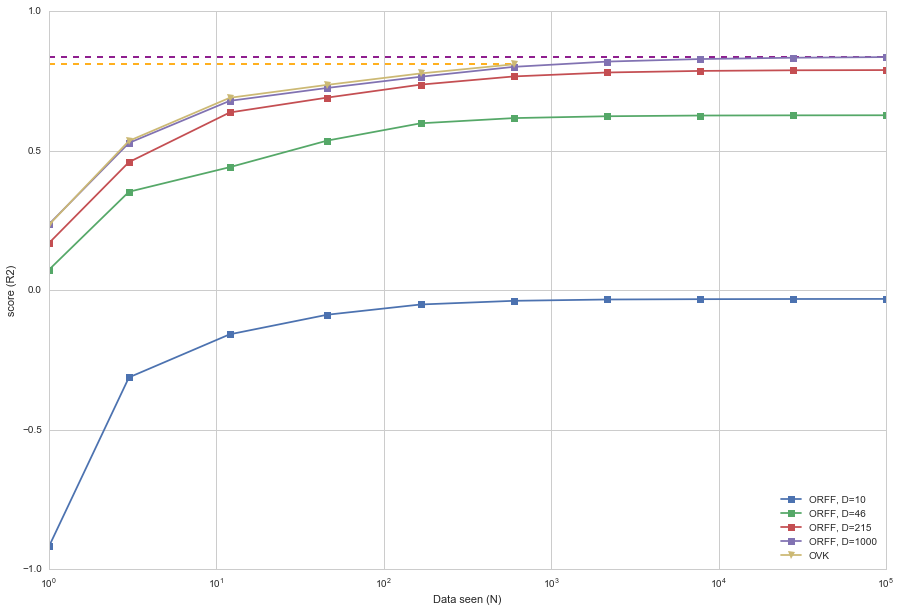

In [56]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,10))

s = -np.isnan(ovke).sum() - 1 if np.isnan(ovke).sum() > 0 else ovke.size - 1
for s, D in enumerate(isp2[::3]):
    ax.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int), rffe[:, 3 * s], label='ORFF, D=' + str(D), marker='s')
ax.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int)[:9 + 1], ovke[:9 + 1], label='OVK', marker='v')
ax.hlines(rffe.max(), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[-1], colors='purple', linestyle='--')
ax.hlines(np.nanmax(ovke), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[5], colors='orange', linestyle='--')
ax.set_xlabel('Data seen (N)')
ax.set_ylabel('score (R2)')
ax.legend(loc=4)

plt.savefig("ORFFFvsOVK_Dvariation.pgf")
plt.show()

In [55]:
ax.hlines?

In [2]:
from sklearn.kernel_approximation import RBFSampler
import autograd.numpy as np   # Thinly-wrapped version of Numpy
import operalib as ovk
from autograd import elementwise_grad
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

d = 5
n = int(np.sqrt(50000)) ** 2

np.random.seed(0)

D = 2000
amp = 2.5
W = amp * np.random.randn(d, D)
coefs = np.random.randn(2 * D, 1)

Xg = 2 * np.random.rand(n, d) - 1

def f(X):
    Z = np.dot(X, W)
    return np.dot(np.hstack((np.cos(Z), np.sin(Z))), coefs)


g = elementwise_grad(f)
yg = g(Xg)
yg = yg / np.linalg.norm(yg)

X, Xtest, y, ytest = train_test_split(Xg, yg)
y = y + .5 * y.std() * np.random.randn(y.shape[0], y.shape[1])
import numpy as np

In [3]:
n = X.shape[0]
Dmax = 1000
Nmax = 1000
gamma = 1 / (2 * np.median(pdist(X) ** 2))
lbda = .5
steps = 10

print('Curl OVK N experiment')
isp = np.logspace(1, np.log10(n), steps).astype(np.int)
ovkt = np.zeros(isp.size)
ovke = np.zeros(isp.size)
for s, idx in enumerate(isp):
    if idx > Nmax:
        ovke[s:] = np.NaN
        ovkt[s:] = np.NaN
        break
    start = time.time()
    est = ovk.OVKRidge(kernel=ovk.RBFCurlFreeKernel(gamma=gamma), lbda=lbda, solver_params={'m': idx, 'pgtol':1e-10})
    est.fit(X[:idx, :], y[:idx, :])
    ovke[s] = est.score(Xtest, ytest)
    ovkt[s] = time.time() - start
    print(ovke[s], ovkt[s])
    
print('Dec OVK N experiment')
isp = np.logspace(1, np.log10(n), steps).astype(np.int)
ovktDec = np.zeros(isp.size)
ovkeDec = np.zeros(isp.size)
for s, idx in enumerate(isp):
    if idx > Nmax:
        ovkeDec[s:] = np.NaN
        ovktDec[s:] = np.NaN
        break
    start = time.time()
    est = ovk.OVKRidge(kernel='DGauss', gamma=gamma, lbda=lbda, solver_params={'m': idx, 'pgtol':1e-10})
    est.fit(X[:idx, :], y[:idx, :])
    ovkeDec[s] = est.score(Xtest, ytest)
    ovktDec[s] = time.time() - start
    print(ovkeDec[s], ovktDec[s])

print('Curl ORFF N experiment')
isp = np.logspace(1, np.log10(n), steps).astype(np.int)
rffe = np.zeros(isp.size)
rfft = np.zeros(isp.size)
for s, idx in enumerate(isp):
    start = time.time()
    est = ovk.ORFFRidge(kernel=ovk.RBFCurlFreeKernel(gamma=gamma), D=Dmax, lbda=lbda, solver_params={'m': Dmax, 'pgtol':1e-10})
    est.fit(X[:idx, :], y[:idx, :])
    rffe[s] = est.score(Xtest, ytest)
    rfft[s] = time.time() - start
    print(rffe[s], rfft[s])
    
print('Dec ORFF N experiment')
isp = np.logspace(1, np.log10(n), steps).astype(np.int)
rffeDec = np.zeros(isp.size)
rfftDec = np.zeros(isp.size)
for s, idx in enumerate(isp):
    start = time.time()
    est = ovk.ORFFRidge(kernel='DGauss', gamma=gamma, D=Dmax, lbda=lbda, solver_params={'m': Dmax, 'pgtol':1e-10})
    est.fit(X[:idx, :], y[:idx, :])
    rffeDec[s] = est.score(Xtest, ytest)
    rfftDec[s] = time.time() - start
    print(rffeDec[s], rfftDec[s])
    
print('OVK D experiment')
est = ovk.OVKRidge(ovk.RBFCurlFreeKernel(gamma=gamma), lbda=lbda, solver_params={'m': Nmax, 'pgtol':1e-10})
start = time.time()
est.fit(X[:Nmax, :], y[:Nmax, :])
ovkDe = est.score(Xtest, ytest)
ovkDt = time.time() - start
print(ovkDe, ovkDt)

print('ORFF D experiment')
isp = np.logspace(1, np.log10(Dmax), steps).astype(np.int)
rffDe = np.zeros(isp.size)
rffDt = np.zeros(isp.size)
for s, D in enumerate(isp):
    start = time.time()
    est = ovk.ORFFRidge(ovk.RBFCurlFreeKernel(gamma=gamma), D=D, lbda=lbda, solver_params={'m': D, 'pgtol':1e-10})
    est.fit(X[:Nmax, :], y[:Nmax, :])
    rffDe[s] = est.score(Xtest, ytest)
    rffDt[s] = time.time() - start
    print(rffDe[s], rffDt[s])

Curl OVK N experiment
0.166574696446 1.00000715256
0.242401813193 1.28277087212
0.407582089572 2.84313893318
0.399417981885 6.03154397011
0.419593521494 14.5996129513
0.422686655324 57.9802129269
Dec OVK N experiment
0.0260199587012 1.45914888382
0.124883108715 1.44467592239
0.300389571322 1.35691905022
0.330911822641 1.81285214424
0.373784124891 1.84823298454
0.395459719298 2.65158700943
Curl ORFF N experiment
0.194213048777 0.950320959091
0.249337857818 0.82838511467
0.434715692598 0.797131061554
0.481812546131 0.98707485199
0.559119753833 1.0358569622
0.643279750812 1.16525101662
0.705803911489 1.41943097115
0.773547246725 2.64081406593
0.805164716894 5.53934192657
0.821949139307 13.16229105
Dec ORFF N experiment
0.023686725793 1.70042204857
0.129949607355 1.50789189339
0.324022566568 1.65651011467
0.415171867305 1.6230711937
0.528886573518 2.17190408707
0.650175887061 1.58686995506
0.716592580072 2.05849599838
0.741009983389 4.27015900612
0.745169191265 7.195510149
0.801735507388 2

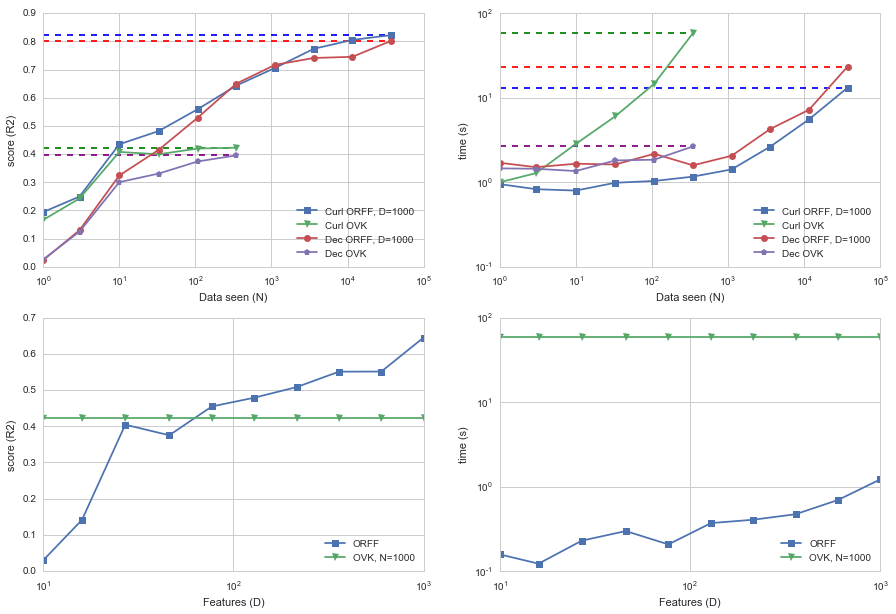

In [4]:
sns.set_style("whitegrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
s = -np.isnan(ovke).sum() - 1 if np.isnan(ovke).sum() > 0 else ovke.size - 1
ax1.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int), rffe, label='Curl ORFF, D=' + str(Dmax), marker='s')
ax1.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int)[:s + 1], ovke[:s + 1], label='Curl OVK', marker='v')
ax1.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int), rffeDec, label='Dec ORFF, D=' + str(Dmax), marker='o')
ax1.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int)[:s + 1], ovkeDec[:s + 1], label='Dec OVK', marker='p')
ax1.hlines(rffe.max(), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[-1], colors='b', linestyle='--')
ax1.hlines(np.nanmax(ovke), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[s], colors='g', linestyle='--')
ax1.hlines(rffeDec.max(), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[-1], colors='r', linestyle='--')
ax1.hlines(np.nanmax(ovkeDec), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[s], colors='purple', linestyle='--')
ax1.set_xlabel('Data seen (N)')
ax1.set_ylabel('score (R2)')
ax1.legend(loc=4)

ax2.loglog(np.logspace(0, np.log10(n), steps).astype(np.int), rfft, label='Curl ORFF, D=' + str(Dmax), marker='s')
ax2.loglog(np.logspace(0, np.log10(n), steps).astype(np.int)[:s + 1], ovkt[:s + 1], label='Curl OVK', marker='v')
ax2.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int), rfftDec, label='Dec ORFF, D=' + str(Dmax), marker='o')
ax2.loglog(np.logspace(0, np.log10(n), steps).astype(np.int)[:s + 1], ovktDec[:s + 1], label='Dec OVK', marker='p')
ax2.hlines(rfft.max(), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[-1], colors='b', linestyle='--')
ax2.hlines(np.nanmax(ovkt), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[s], colors='g', linestyle='--')
ax2.hlines(np.nanmax(rfftDec), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[-1], colors='r', linestyle='--')
ax2.hlines(np.nanmax(ovktDec), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[s], colors='purple', linestyle='--')
ax2.set_xlabel('Data seen (N)')
ax2.set_ylabel('time (s)')
ax2.legend(loc=4)

ax4.loglog(np.logspace(1, np.log10(Dmax), steps).astype(np.int), rffDt, label='ORFF', marker='s')
ax4.loglog(np.logspace(1, np.log10(Dmax), steps).astype(np.int), np.full(steps, ovkDt), label='OVK, N=' + str(Nmax), marker='v')
ax4.set_xlim(10, Dmax)
ax4.set_xlabel('Features (D)')
ax4.set_ylabel('time (s)')
ax4.legend(loc=4)

ax3.semilogx(np.logspace(1, np.log10(Dmax), steps).astype(np.int), rffDe, label='ORFF', marker='s')
ax3.semilogx(np.logspace(1, np.log10(Dmax), steps).astype(np.int), np.full(steps, ovkDe), label='OVK, N=' + str(Nmax), marker='v')
ax3.set_xlim(10, Dmax)
ax3.set_xlabel('Features (D)')
ax3.set_ylabel('score (R2)')
ax3.legend(loc=4)

plt.savefig("Curl_ORFFFvsOVK.pgf")
plt.show()

In [ ]:
print(1)

In [69]:
from sklearn.kernel_approximation import RBFSampler
import autograd.numpy as np   # Thinly-wrapped version of Numpy
import operalib as ovk
from autograd import elementwise_grad
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

d = 5
n = int(np.sqrt(50000)) ** 2


D = 2000
amp = 1.
W = amp * np.random.rand(d, D)
coefs = np.random.randn(2 * D, 1)

Xg = 2 * np.random.rand(n, d) - 1

def f(X):
    Z = np.dot(X, W)
    return np.dot(np.hstack((np.cos(Z), np.sin(Z))), coefs)


g = elementwise_grad(f)
yg = g(Xg)
yg = yg / np.linalg.norm(yg)
yg += .05 * np.random.randn(yg.shape[0], yg.shape[1])

X, Xtest, y, ytest = train_test_split(Xg, yg)
import numpy as np

In [70]:
n = X.shape[0]
Dmax = 1000
Nmax = 1000
gamma = amp ** 2 / 2 
lbda = 1.
steps = 10

# print('Curl OVK N experiment')
# isp = np.logspace(1, np.log10(n), steps).astype(np.int)
# ovkt = np.zeros(isp.size)
# ovke = np.zeros(isp.size)
# for s, idx in enumerate(isp):
#     if idx > Nmax:
#         ovke[s:] = np.NaN
#         ovkt[s:] = np.NaN
#         break
#     start = time.time()
#     est = ovk.OVKRidge(kernel=ovk.RBFCurlFreeKernel(gamma=gamma), lbda=lbda, solver_params={'m': idx, 'pgtol':1e-10})
#     est.fit(X[:idx, :], y[:idx, :])
#     ovke[s] = est.score(Xtest, ytest)
#     ovkt[s] = time.time() - start
#     print(ovke[s], ovkt[s])
    
# print('Dec OVK N experiment')
# isp = np.logspace(1, np.log10(n), steps).astype(np.int)
# ovktDec = np.zeros(isp.size)
# ovkeDec = np.zeros(isp.size)
# for s, idx in enumerate(isp):
#     if idx > Nmax:
#         ovkeDec[s:] = np.NaN
#         ovktDec[s:] = np.NaN
#         break
#     start = time.time()
#     est = ovk.OVKRidge(kernel='DGauss', gamma=gamma, lbda=lbda, solver_params={'m': idx, 'pgtol':1e-10})
#     est.fit(X[:idx, :], y[:idx, :])
#     ovkeDec[s] = est.score(Xtest, ytest)
#     ovktDec[s] = time.time() - start
#     print(ovkeDec[s], ovktDec[s])

print('Curl ORFF N experiment')
isp = np.logspace(1, np.log10(n), steps).astype(np.int)
rffe = np.zeros(isp.size)
rfft = np.zeros(isp.size)
for s, idx in enumerate(isp):
    start = time.time()
    est = ovk.ORFFRidge(kernel=ovk.RBFCurlFreeKernel(gamma=gamma), D=Dmax, lbda=lbda, solver_params={'m': Dmax, 'pgtol':1e-10})
    est.fit(X[:idx, :], y[:idx, :])
    rffe[s] = est.score(Xtest, ytest)
    rfft[s] = time.time() - start
    print(rffe[s], rfft[s])
    
print('Dec ORFF N experiment')
isp = np.logspace(1, np.log10(n), steps).astype(np.int)
rffeDec = np.zeros(isp.size)
rfftDec = np.zeros(isp.size)
for s, idx in enumerate(isp):
    start = time.time()
    est = ovk.ORFFRidge(kernel='DGauss', gamma=gamma, D=Dmax, lbda=lbda, solver_params={'m': Dmax, 'pgtol':1e-10})
    est.fit(X[:idx, :], y[:idx, :])
    rffeDec[s] = est.score(Xtest, ytest)
    rfftDec[s] = time.time() - start
    print(rffeDec[s], rfftDec[s])
    
print('OVK D experiment')
est = ovk.OVKRidge(ovk.RBFCurlFreeKernel(gamma=gamma), lbda=lbda, solver_params={'m': Nmax, 'pgtol':1e-10})
start = time.time()
est.fit(X[:Nmax, :], y[:Nmax, :])
ovkDe = est.score(Xtest, ytest)
ovkDt = time.time() - start
print(ovkDe, ovkDt)

print('ORFF D experiment')
isp = np.logspace(1, np.log10(Dmax), steps).astype(np.int)
rffDe = np.zeros(isp.size)
rffDt = np.zeros(isp.size)
for s, D in enumerate(isp):
    start = time.time()
    est = ovk.ORFFRidge(ovk.RBFCurlFreeKernel(gamma=gamma), D=D, lbda=lbda, solver_params={'m': D, 'pgtol':1e-10})
    est.fit(X[:Nmax, :], y[:Nmax, :])
    rffDe[s] = est.score(Xtest, ytest)
    rffDt[s] = time.time() - start
    print(rffDe[s], rffDt[s])

Curl ORFF N experiment
-0.066198584795 1.18074297905
-0.102577774937 0.620791912079
-0.104781828931 0.87989282608
-0.0811469665911 0.888353824615
-0.0530324378667 0.705269098282
-0.0237622335593 1.25226593018
-0.0142818858069 1.97660684586
-0.00810342657855 3.49058318138
-0.00360099191233 8.65974998474
-0.00172087532491 42.6822509766
Dec ORFF N experiment
-0.0533893132356 1.32265591621
-0.152902545059 12.4432229996
-0.0941050551731 0.477478027344
-0.0846838139204 0.490611791611
-0.0596740951504 0.506021976471
-0.0418651689184 0.630010843277
-0.0257479307872 0.971225976944
-0.015812827495 1.54568314552
-0.0094449783305 4.32551002502
-0.00466613694103 10.9764909744
OVK D experiment
-0.030130957721 32165.00256204605
ORFF D experiment
-0.00238560802583 0.0708220005035
-0.00412321587968 0.0436310768127
-0.00548174751176 0.101389169693
-0.00568534724914 0.0690240859985
-0.00771272820579 0.0934839248657
-0.0105663051208 0.157403945923
-0.0156674809079 0.229926109314
-0.0178402898954 0.3740019

In [ ]:
sns.set_style("whitegrid")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(15,10))
s = -np.isnan(ovke).sum() - 1 if np.isnan(ovke).sum() > 0 else ovke.size - 1
ax1.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int), rffe, label='Curl ORFF, D=' + str(Dmax), marker='s')
ax1.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int)[:s + 1], ovke[:s + 1], label='Curl OVK', marker='v')
ax1.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int), rffeDec, label='Dec ORFF, D=' + str(Dmax), marker='o')
ax1.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int)[:s + 1], ovkeDec[:s + 1], label='Dec OVK', marker='p')
ax1.hlines(rffe.max(), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[-1], colors='b', linestyle='--')
ax1.hlines(np.nanmax(ovke), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[s], colors='g', linestyle='--')
ax1.hlines(rffeDec.max(), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[-1], colors='r', linestyle='--')
ax1.hlines(np.nanmax(ovkeDec), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[s], colors='purple', linestyle='--')
ax1.set_xlabel('Data seen (N)')
ax1.set_ylabel('score (R2)')
ax1.legend(loc=4)

ax2.loglog(np.logspace(0, np.log10(n), steps).astype(np.int), rfft, label='Curl ORFF, D=' + str(Dmax), marker='s')
ax2.loglog(np.logspace(0, np.log10(n), steps).astype(np.int)[:s + 1], ovkt[:s + 1], label='Curl OVK', marker='v')
ax2.semilogx(np.logspace(0, np.log10(n), steps).astype(np.int), rfftDec, label='Dec ORFF, D=' + str(Dmax), marker='o')
ax2.loglog(np.logspace(0, np.log10(n), steps).astype(np.int)[:s + 1], ovktDec[:s + 1], label='Dec OVK', marker='p')
ax2.hlines(rfft.max(), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[-1], colors='b', linestyle='--')
ax2.hlines(np.nanmax(ovkt), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[s], colors='g', linestyle='--')
ax2.hlines(np.nanmax(rfftDec), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[-1], colors='r', linestyle='--')
ax2.hlines(np.nanmax(ovktDec), xmin=1, xmax=np.logspace(0, np.log10(n), steps).astype(np.int)[s], colors='purple', linestyle='--')
ax2.set_xlabel('Data seen (N)')
ax2.set_ylabel('time (s)')
ax2.legend(loc=4)

ax4.loglog(np.logspace(1, np.log10(Dmax), steps).astype(np.int), rffDt, label='ORFF', marker='s')
ax4.loglog(np.logspace(1, np.log10(Dmax), steps).astype(np.int), np.full(steps, ovkDt), label='OVK, N=' + str(Nmax), marker='v')
ax4.set_xlim(10, Dmax)
ax4.set_xlabel('Features (D)')
ax4.set_ylabel('time (s)')
ax4.legend(loc=4)

ax3.semilogx(np.logspace(1, np.log10(Dmax), steps).astype(np.int), rffDe, label='ORFF', marker='s')
ax3.semilogx(np.logspace(1, np.log10(Dmax), steps).astype(np.int), np.full(steps, ovkDe), label='OVK, N=' + str(Nmax), marker='v')
ax3.set_xlim(10, Dmax)
ax3.set_xlabel('Features (D)')
ax3.set_ylabel('score (R2)')
ax3.legend(loc=4)

plt.savefig("Curl_ORFFFvsOVK.pgf")
plt.show()